# Spectrotemporal Decompositions

This notebook demonstrates usage of the framework for spectrotemporal decompositions. Additionally, it is used to create Fig. 2 in section IV.B.

In addition to the usual suspects (```matplotlib```, ```numpy```), we'll import the ```lrsd``` and ```spec_pursuit``` methods from the ***../python*** directory.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import seaborn as sns
sns.set(rc={'image.cmap': 'jet'})
%matplotlib inline

import matplotlib

import scipy.io as sio
from scipy.signal import butter, lfilter

import sys
sys.path
sys.path.append('../python/')
from spec_temp import lrsd, spec_pursuit

# Temporary to avoid the "if self._edgecolors == str('face')" FutureWarning
import warnings
warnings.filterwarnings('ignore')

Next we'll generate the signal on which to perform spectral analysis. Specifically, the signal is given by:

$$
y(t) = 10\cos^8(2 \pi f_0 t)\sin(2 \pi f_1 t) + 10 \exp\left(4\frac{t-T}{T}\right) \cos(2 \pi f_2 t) + v(t)
$$

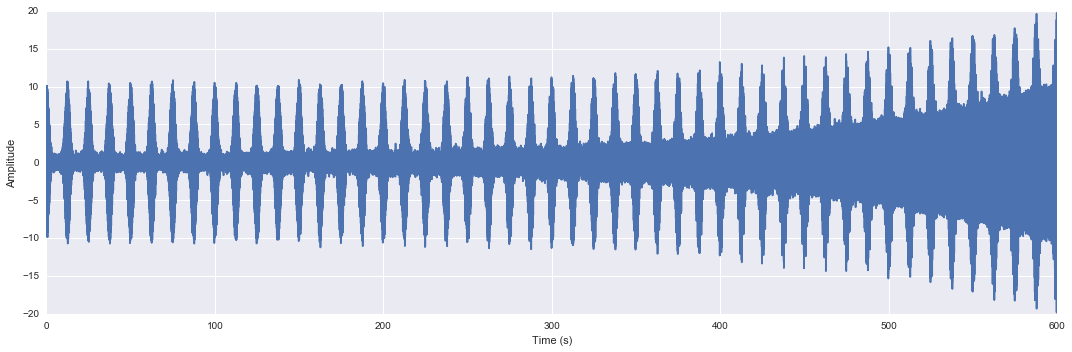

In [28]:
T  = 600   #[s]
fs = 500   #[Hz]
f0 = 0.04  #[Hz]
f1 = 10    #[Hz]
f2 = 11    #[Hz]
noise_var = 1.0

t = np.linspace(0,T,fs*T)
signal = 10*(np.cos(2*np.pi*f0*t))**8*np.sin(2*np.pi*f1*t) + \
         10*np.exp(4*(t-T)/T)*np.cos(2*np.pi*f2*t)
noise = np.random.normal(0,noise_var,T*fs)
signal = signal + noise
from scipy.signal import decimate
dec = 4
signal = decimate(signal,dec)
fs = fs//dec

plt.figure(figsize=(15,5))
plt.plot(np.linspace(0,T,len(signal)),signal)
plt.ylim([-20,20])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout();

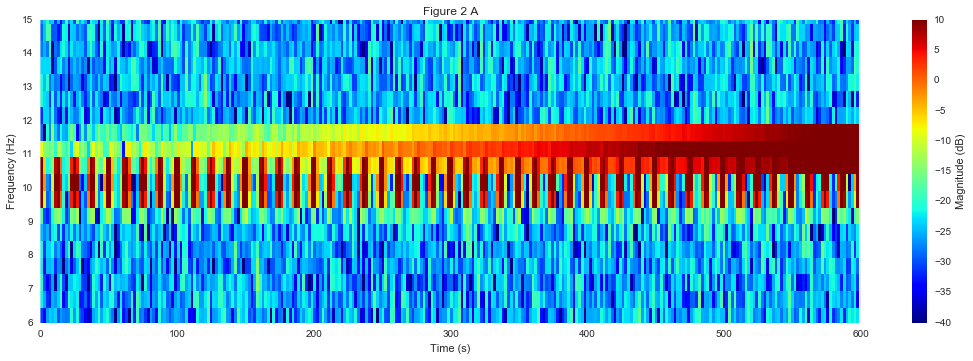

In [29]:
fig, ax = plt.subplots(figsize=(15,5))
im0 = ax.specgram(signal,NFFT=1000//dec,Fs=500//dec,noverlap=0,interpolation='none',aspect='auto')#,window=matplotlib.mlab.window_none)
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (s)')
im0[3].set_clim((-40,10))
ax.set_ylim([6,15])
cb = fig.colorbar(im0[3],label='Magnitude (dB)')
fig.tight_layout()
plt.grid('off')
plt.title('Figure 2 A');

Next we generate the Spec Pursuit estimates. The parameters are:

- $K$ (```K```): Number of frequency coefficients (effectively $K/2$ given each needs Re/Im pair)
- $L$ (```L```): Windown length (traditionally $L\le K$, but this is not necessary in this case)
- $\rho$ (```rho```): ADMM penalty parameter. Acts as step size for dual ascent component of ADMM
- $\beta$ (```beta```): Prior parameter. Determines how heavily we weight measurements vs. prior

Additionally, both have the optional parameters:

- ```max_iters```: Maximum number of ADMM iterations (*default is 10*)
- ```verbosity```: Determines how much will be printed. 0 is nothing, 1 signals beginning and provides a summary, and > 1 would be used for debugging (*default is 0*)
- ```overlap```: Overlap of time windows, given as a decimal between 0 and 1. i.e. 75% overlap would be 0.75 (*default is 0*)
- ```thresh```: Where residual levels should be to determine convergence (*default is 0.0001*)

In [8]:
K = fs*2     # This gives us a resolution of 1 Hz per bin to distinguish between 10 and 11 Hz
L = K//8     # As w/ standard specgram, window length = # frequency bins

rho = 500
beta = 10000
max_iters = 500
verbosity = 1


(x_spec,x_spec_mag) = spec_pursuit(signal,rho,K,L,beta,max_iters=max_iters,verbosity=verbosity)

L%K != 0 - Creating F for each n
Beginning ADMM Iterations


Total runtime: 217.60154485702515 seconds
Total number of iterations: 500
Norm of differences between x and z: 0.000495707066656
Norm of differences between w and z differences: 0.0429251734623
Average Update Times:
x - 0.1644138832092285 seconds
w - 0.02830491876602169 seconds
z - 0.0815496139526368 seconds
lambda - 0.007124545097351077 seconds
alpha - 0.02189245986938478 seconds
---------------------------------------



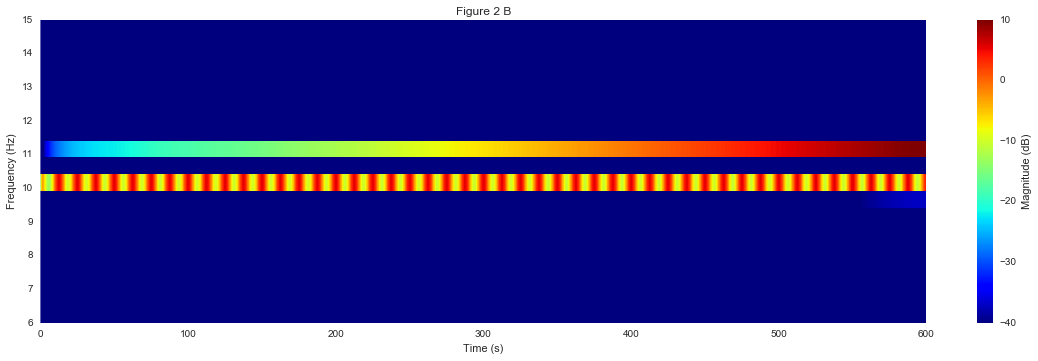

In [26]:
fig, ax = plt.subplots(figsize=(15,5))
x = x_spec_mag - np.max(x_spec_mag)+10
im1 = ax.imshow(x,origin='lower',aspect='auto',interpolation='none',extent=(0,T,0,K//4))
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (s)')
im1.set_clim((-40,10))
ax.set_ylim([6,15])
cb = fig.colorbar(im1,fraction=0.086,label='Magnitude (dB)',ticks=[-40,-30,-20,-10,0,10])
ax.grid('off')
fig.tight_layout()
plt.title("Figure 2 B");

Next we'll load the real data and look at the low-rank spectrotemporal decomposition of it (after some preprocessing).

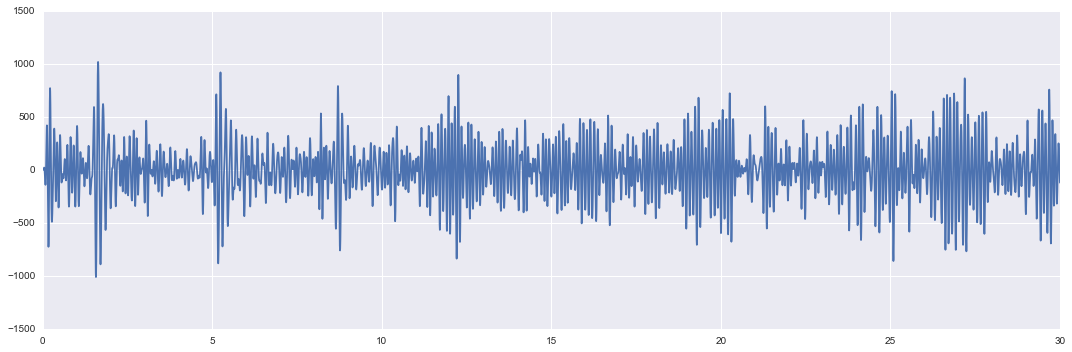

In [16]:
signal = sio.loadmat('../../data/eeg_data/GO-N2-e3a.mat',squeeze_me=1)['new']

n = np.arange(len(signal))

fs = 500
nyq = 250

b,a = butter(6,[6/nyq,14/nyq],btype='band')
signal = lfilter(b,a,signal)

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(n/fs,signal)
fig.tight_layout()

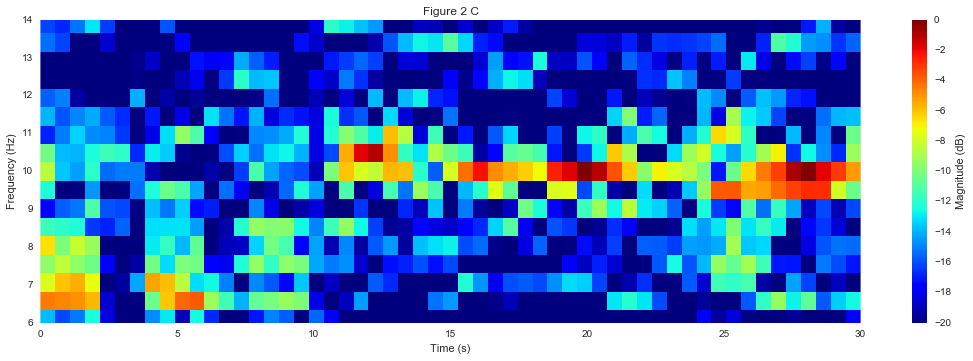

In [25]:
L = 256*4               
noverlap = 0

coeffs,freqs,t = mlab.specgram(signal,NFFT=L,Fs=fs,noverlap=L*0.75,window=mlab.window_none)
coeffs = 10*np.log10(coeffs)
coeffs = coeffs - np.max(coeffs)
#coeffs = coeffs - np.max(coeffs)
fig, ax = plt.subplots(figsize=(15,5))
im1 = ax.imshow(coeffs,origin='lower',extent=[0,len(signal)/fs,0,fs/2],aspect='auto',interpolation='none')
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (s)')
im1.set_clim(-20,0)
ax.set_ylim([6,14])
ax.grid('off')
cb = fig.colorbar(im1,label='Magnitude (dB)')
plt.tight_layout()
plt.title("Figure 2 C");

L%K != 0 - Creating F for each n
Beginning ADMM Iterations


Total runtime: 11.37508487701416 seconds
Total number of iterations: 200
Norm of differences between x and z: 0.0794071314339
Norm of differences between w and z differences: 1.41694935178
Average Update Times:
x - 0.03319850564002989 seconds
w - 0.011702929735183725 seconds
z - 0.009079965353012085 seconds
lambda - 0.00046027660369873035 seconds
alpha - 0.000930001735687256 seconds
---------------------------------------



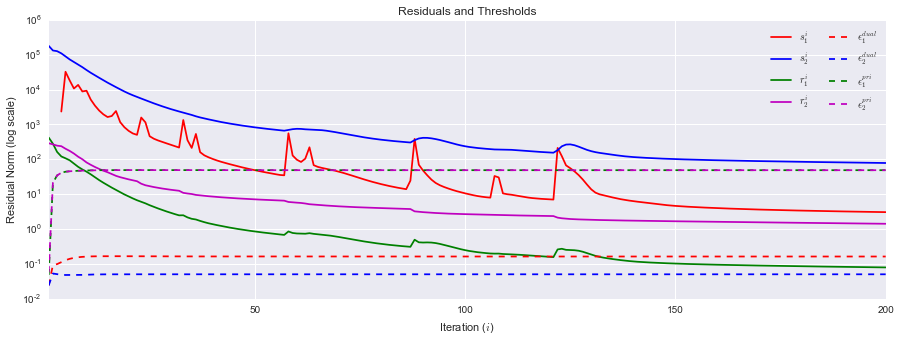

In [21]:
(coeffs_full,coeffs_mag) = spec_pursuit(signal=signal,rho=500,K=L,L=L//4,overlap=0,beta=150000,max_iters=200,verbosity=2)
coeffs_mag -= np.max(coeffs_mag)

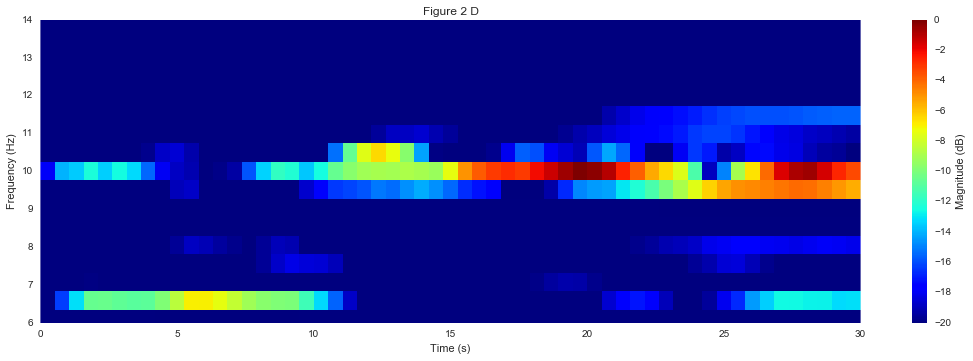

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
im1 = ax.imshow(coeffs_mag,vmin=-20,vmax=0,origin='lower',extent=[0,len(signal)//fs,0,fs//2],aspect='auto',interpolation='none')
ax.axis('tight')
ax.set_ylim([6,14]);
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (s)')
cb = plt.colorbar(im1,label="Magnitude (dB)")
ax.grid('off');
plt.tight_layout()
plt.title("Figure 2 D");